## Tutorial 7: Using PyBEAM to fit a model to experimental data.

In this tutorial, we demonstrate how to use PyBEAM to fit model parameters to an experiment's data set. Specifically, we use data collected by Evans et al. (2020) in their publication "The Role of Passing Time in Decision Making". In this notebook, we fit data from the first experiment listed in their paper.

In this experiment, participants were given random dot coherence task with four coherence conditions: 0%, 5%, 10%, and 40%. Reward rate was emphasized, with particpants instructed to maximize the number of correct decisions. The had a fixed time of 5 seconds in which to make the choice.

First, we import PyBEAM's default module. Additionally, we import a python script which sorts the Evans data (parse_Evans2020) and numpy in order to load data files.


In [1]:
# import PyBEAM's default module
import pybeam.default as pbd

# import sript to parse Evans data
from parse_Evans2020 import subject_rt

# import numpy to load Evans data
import numpy as np


The next block of code imports and sorts the Evans experiment 1 data set. We first load the data and subject labels using numpy and place them in arrays. Data contains the participant number, choice made (correct or incorrect), coherence (0%, 5%, 10% or 40%), and reaction time. Subjects contains the list of participants.

To sort out the data for a single participant, we call the subject_rt function. It takes as an input the data and subjects array, in addition to the subject number we would like to fit, and minimum rt value (filters out data below this value, as done in Evans) and a max rt value (filters out data above this value, as done in Evans).

The function outputs a dictionary containing four keys: 'rt0', 'rt5', 'rt10' and 'rt40'. These contain dictionaries holding the reaction time data for each of the four coherence conditions. Each sub-dictionary contains two entries: 'rt_upper' and 'rt_lower'. 'rt_upper' contains an array of rt values corresponding to the correct choice. 'rt_lower' contains an array of values containing the rt values corresponding to an error. It outputs this particular structure becauase is the data structure required by PyBEAM.


In [2]:
# import rt data from Evans2020 Experiment 1
data = np.asarray(np.loadtxt(open("Exp1_data.csv", "rb"), delimiter=",", skiprows=1))

# import subject labels from Evans2020
subjects = np.asarray(np.loadtxt(open("Exp1_subjects.csv", "rb"), delimiter=",", skiprows=1))

# subject to fit model to (from list subjects)
subject_number = 31727

# filter data below min_rt and above max_rt
min_rt = 0.25
max_rt = 5.0

# file name to save posteriors to
file_name = 'subject_' + str(int(subject_number))

# return rt for desired subject number
rt = subject_rt(subject_number = subject_number, 
                          data = data, 
                      subjects = subjects, 
                        min_rt = min_rt, 
                        max_rt = max_rt)

rt


{'rt0': {'rt_upper': array([0.851, 1.321, 0.976, 3.256, 2.965, 0.882, 3.238, 2.714, 2.534,
         1.226, 1.752, 0.738, 2.277, 1.186, 2.323, 2.699, 2.242, 0.997,
         2.15 , 3.169, 1.248, 0.986, 1.139, 1.772, 1.153, 1.65 , 1.126,
         1.495, 0.552, 0.571, 0.689, 0.831, 0.641, 1.085, 1.172, 1.297,
         0.655, 0.567, 1.334, 0.801, 0.699, 0.579, 0.614, 0.785, 1.554,
         1.611, 1.344, 0.882, 0.678, 0.847, 0.553, 0.364, 0.779, 0.842,
         0.878, 0.719, 0.829, 2.937, 0.416, 0.677, 0.703, 1.163, 0.637,
         0.684, 1.137, 0.579, 0.822, 0.742, 0.397, 0.86 , 0.832, 0.919,
         0.937, 0.578, 1.034, 0.74 , 0.696, 2.303, 0.888, 0.805, 0.803,
         0.728, 1.153, 1.006, 0.726, 0.817, 1.686, 2.058, 1.49 , 1.739,
         2.875, 1.079, 1.681, 1.677, 0.784, 1.251, 0.714, 1.131, 0.661,
         0.964, 1.393, 0.897, 0.987, 0.524, 0.628, 1.315, 1.205, 1.76 ,
         0.823, 0.731, 0.859, 0.696, 0.852, 0.663, 0.539, 0.696, 0.56 ,
         0.761, 0.519, 0.488, 0.453, 0.732, 0

Now that we have imported our data, we now define our model. Following Evans, we fit a base model with a weibull threshold and uniform contamination. The dictionary required for this is below.


In [3]:
# define model
model = {'type' : 'base',    # model type ('base' or 'ugm')
        'sigma' : 1.0,       # sets sigma, the noise parameter
    'threshold' : 'weibull', # sets threshold type (fixed, linear, exponential, or weibull)
      'leakage' : False,     # if True, drift rate has leaky integration
        'delay' : False,     # if True, decision threshold motion is delayed (only for non-fixed thresholds)
'contamination' : True}      # if True, uniform contamination added ot model

# outputs which parameters your model uses
pbd.parse_model(model)


['t_nd', 'w', 'mu', 'a', 'lamb', 'kappa', 'c', 'g', 'gl', 'gu']

Now that we have defined our model, we can define our priors, conditions, and run the inference program. Since we have four coherences, we will have four model conditions, each with their own unique drift rate prior. Each model condition has its own data set, corresponding to one of the four coherences. Following Evans, we assume that the threshold will collapse completely from its initial location, so we set the collapse parameter, c, to -1 in the priors dictionary. We also assume that the uniform contamination can occur as any time between the min and max rt values, so we set the lower and upper contaminations to be theses values.


In [4]:
# define priors
p = {'pt_nd' : 'Uniform("t_nd", lower = 0.0, upper = 0.75)',  # prior for non-decision time
        'pw' : 'Uniform("w", lower = 0.3, upper = 0.7)',      # prior for relative start
      'pmu0' : 'Uniform("mu0", lower = -5.0, upper = 5.0 )',  # drift rate prior for coherence 0%
      'pmu5' : 'Uniform("mu5", lower = -5.0, upper = 5.0)',   # drift rate prior for choherence 5%
     'pmu10' : 'Uniform("mu10", lower = -5.0, upper = 5.0)',  # drift rate prior for coherence 10%
     'pmu40' : 'Uniform("mu40", lower = -5.0, upper = 5.0)',  # drift rate prior for coherence 40%
        'pa' : 'Uniform("a", lower = 0.25, upper = 2.0)',     # prior for threshold location
     'plamb' : 'Uniform("lamb", lower = -1.0, upper = 2.0)',  # prior for scale parameter
    'pkappa' : 'Uniform("kappa", lower = -1.0, upper = 2.0)', # prior for shape parameter
         'c' : -1.0,                                          # collapse parameter value
        'pg' : 'Uniform("g", lower = 0.0, upper = 0.75)',     # prior for contamination strength
        'gl' : min_rt,                                        # uniform contamination lower bound
        'gu' : max_rt}                                        # uniform contamination upper bound

# model condition for coherence 0%
c0 = {'rt' : rt['rt0'],
    't_nd' : 'pt_nd',
       'w' : 'pw',
      'mu' : 'pmu0',
       'a' : 'pa',
    'lamb' : 'plamb',
   'kappa' : 'pkappa',
       'c' : 'c',
       'g' : 'pg',
      'gl' : 'gl',
      'gu' : 'gu'}

# model condition for coherence 5%
c5 = {'rt' : rt['rt5'],
    't_nd' : 'pt_nd',
       'w' : 'pw',
      'mu' : 'pmu5',
       'a' : 'pa',
    'lamb' : 'plamb',
   'kappa' : 'pkappa',
       'c' : 'c',
       'g' : 'pg',
      'gl' : 'gl',
      'gu' : 'gu'}

# model condition for coherence 10%
c10 = {'rt' : rt['rt10'],
      't_nd' : 'pt_nd',
         'w' : 'pw',
        'mu' : 'pmu10',
         'a' : 'pa',
      'lamb' : 'plamb',
     'kappa' : 'pkappa',
         'c' : 'c',
         'g' : 'pg',
        'gl' : 'gl',
        'gu' : 'gu'}

# model condition for coherence 40%
c40 = {'rt' : rt['rt40'],
     't_nd' : 'pt_nd',
        'w' : 'pw',
       'mu' : 'pmu40',
        'a' : 'pa',
     'lamb' : 'plamb',
    'kappa' : 'pkappa',
        'c' : 'c',
        'g' : 'pg',
       'gl' : 'gl',
       'gu' : 'gu'}

# load conditions into dictionary
cond = {0 : c0, 1 : c5, 2 : c10, 3 : c40}

# run parameter inference
trace = pbd.inference(model = model,
                     priors = p,
                 conditions = cond,
                    samples = 50000,
                     chains = 3,
                      cores = 3,
                  file_name = file_name)


Multiprocess sampling (3 chains in 3 jobs)
DEMetropolisZ: [g, kappa, lamb, a, mu40, mu10, mu5, mu0, w, t_nd]


Sampling 3 chains for 0 tune and 50_000 draw iterations (0 + 150_000 draws total) took 314 seconds.


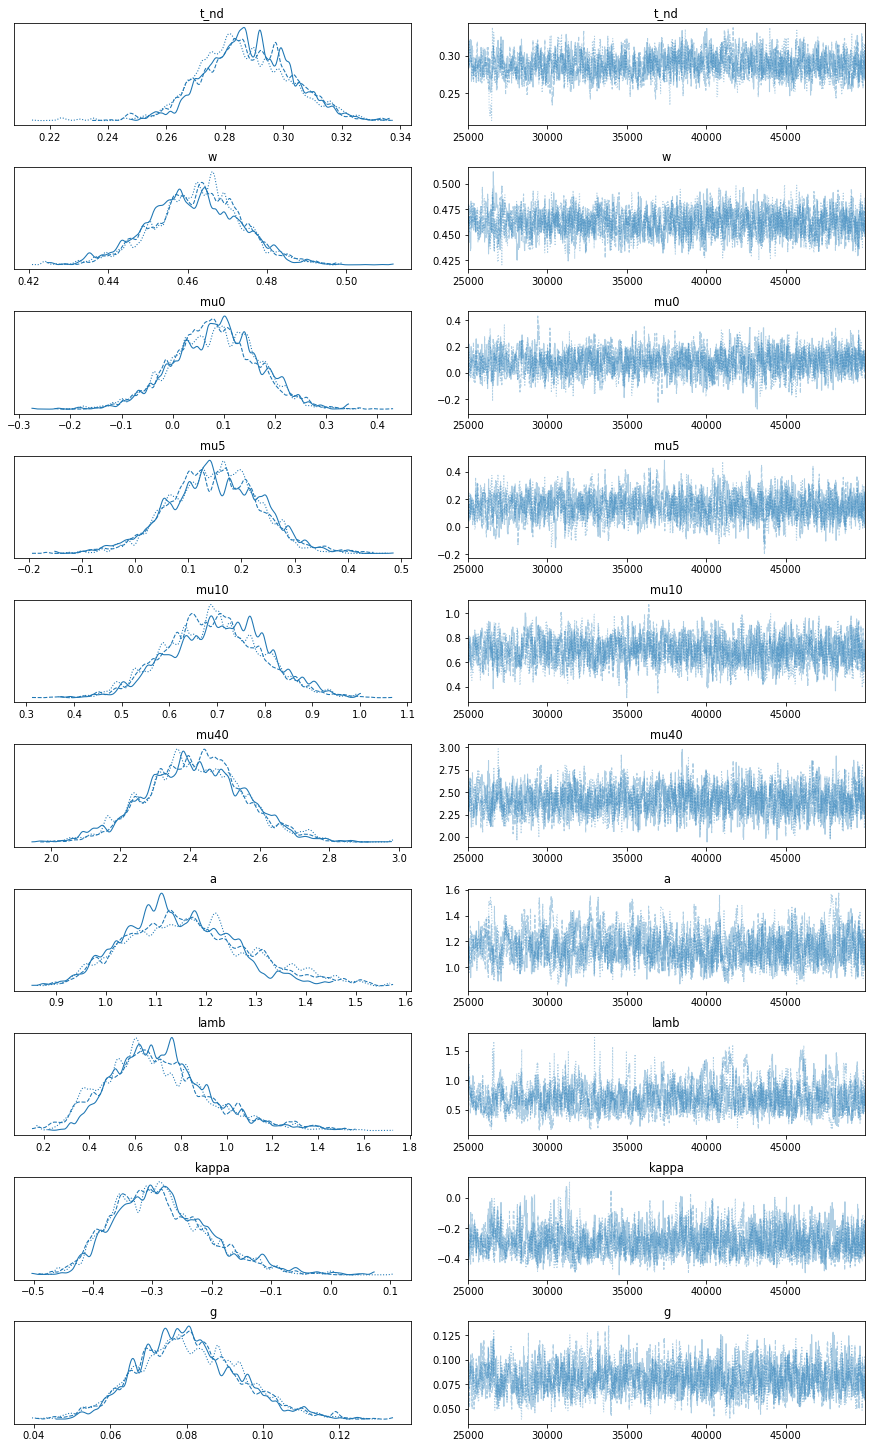

In [5]:
# plot posteriors
pbd.plot_trace(file_name = file_name, burnin = 25000);


In [6]:
# posterior summary
pbd.summary(file_name = file_name, burnin = 25000);
